# Importing Dataset

In [1]:
import pandas as pd
import logging
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Suppress specific sklearn warnings
warnings.filterwarnings("ignore", category=UserWarning) 
# Suppress the specific PyTorch warning about uninitialized weights
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Loading Dataset

In [2]:
# Load the training and testing data   
train_df = pd.read_csv('train.csv')
valid_df=pd.read_csv('valid.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df

,crawled_date,country_of_origin,label,url,lang,claim,doc,taxonomy_label,label_original
0,2019-07-06,india,False,https://www.indiatoday.in/fact-check/story/fac...,en,"In her budget speech, Nirmala Sitharaman claim...",Did Finance Minister Nirmala Sitharaman claim ...,statistical,False
1,2022-10-07T03:00:06,usa,False,https://www.snopes.com/fact-check/florida-food...,en,Florida residents affected by Hurricane Irma c...,"In September 2017, Facebook users spread sever...",interval,Mostly False
2,2023-05-25T15:13:20,france,False,https://factcheck.afp.com/gates-foundation-tar...,en,Bill Gates' foundation tested a polio vaccine ...,“Bill Gates foundation tested a polio vax in I...,statistical,Misleading
3,NaN,usa,False,https://www.politifact.com/factchecks/2016/jul...,en,"SaysHillary Clinton ""took 13 hours to send hel...",Vice presidential nominees are often expected ...,statistical,false
4,2022-10-06T21:00:06,usa,False,https://www.politifact.com/factchecks/2022/aug...,en,"""Send your postcards to 5 key states to decert...",A Facebook post promotes a website that charge...,statistical,pants-fire
...,...,...,...,...,...,...,...,...,...
9930,NaN,usa,Conflicting,https://www.politifact.com/factchecks/2016/feb...,en,"Americans ""are working longer hours for low wa...",Sen. Bernie Sanders repeated his ongoing theme...,comparison,half-true
9931,2018-05-07,usa,Conflicting,https://www.snopes.com/fact-check/lynched-okla...,en,"Two black men, Alize Ramon Smith and Jarron Ke...","On 18 April 2018, the mutilated bodies of two ...",statistical,Mixture
9932,NaN,usa,Conflicting,https://www.politifact.com/factchecks/2018/aug...,en,"""Trump just gave a $12 billion bailout to farm...",President Donald Trump has recently faced crit...,statistical,barely-true
9933,NaN,usa,Conflicting,https://www.politifact.com/factchecks/2016/aug...,en,"""Hillary [Clinton] wants to raise taxes by ove...",During a campaign stop in Bucks County this we...,statistical,half-true


In [4]:
valid_df

,crawled_date,country_of_origin,label,url,lang,claim,doc,taxonomy_label,label_original
0,2022-02-23,india,False,https://www.indiatoday.in/fact-check/story/fac...,en,Amit Shah said Narendra Modi sleeps for 24 hou...,The India Today Anti-Fake News War Room found ...,interval,Mostly false
1,2023-09-09T16:45:17,NaN,False,https://newsmobile.in/articles/2023/09/06/fact...,en,Video of show Pakistani players celebrating th...,The first Asia Cup encounter between India and...,temporal,Misleading
2,NaN,usa,True,https://www.politifact.com/factchecks/2018/sep...,en,"Says Dino Rossi ""stripped"" health care ""from 4...","Did Dino Rossi, a Republican Washington state ...",statistical,mostly-true
3,2023-02-13T18:00:05,germany,False,https://correctiv.org/faktencheck/2021/02/03/v...,en,Durch einen Vergleich mit den Symptomen einer ...,Die Facebook-Seite „Dr. Rüdiger Dahlke“ veröff...,interval,Fehlender Kontext
4,2022-10-07T03:00:06,usa,False,https://www.snopes.com/fact-check/grambo/,en,A gun-toting Australian granny blew the testic...,"MELBOURNE, Australia Gun-toting granny Ava Est...",statistical,False
...,...,...,...,...,...,...,...,...,...
3079,2022-10-07T09:00:06,usa,False,https://www.snopes.com/fact-check/zuckerberg-d...,en,"Mark Zuckerberg is giving $1,000 away to Faceb...","On 31 December 2015, the British spoof and sat...",statistical,False
3080,2023-05-25T15:48:04,france,False,https://factcheck.afp.com/doc.afp.com.32N22RR-1,en,Joe Biden said Democrats would cheat in 2022 b...,"""Joe Biden announced to the world tonight that...",temporal,False
3081,NaN,usa,False,https://www.politifact.com/factchecks/2018/may...,en,"""CNN to permanently close its doors as ratings...",CNN’s ratings drop in one week has caused the ...,statistical,false
3082,NaN,usa,Conflicting,https://www.politifact.com/factchecks/2016/dec...,en,"A recent study found ""that cities where Uber o...","More than 43,000 people in upstate New York op...",comparison,half-true


In [5]:
test_df

,country_of_origin,label,url,lang,claim,doc,taxonomy_label,label_original,crawled_date
0,usa,Conflicting,https://www.politifact.com/factchecks/2012/apr...,en,"""The non-partisan Congressional Budget Office ...",Republican U.S House candidate Roger Williams ...,statistical,barely-true,NaN
1,usa,True,https://www.politifact.com/factchecks/2014/jul...,en,"""More than 50 percent of immigrants from (El S...",The crisis at the border brought on by thousan...,statistical,mostly-true,NaN
2,france,False,https://factcheck.afp.com/doc.afp.com.32JN4VX-1,en,UK government banned Covid vaccine for childre...,"""BREAKING: Children in the UK aged 5-11 will n...",temporal,False,2023-05-25T16:11:28
3,south africa,False,https://africacheck.org/fact-checks/reports/cr...,en,"""[In 2014-2015] coverage for the rotavirus vac...",When doctors working in Free State government ...,statistical,misleading,2023-05-25T17:01:45
4,usa,True,https://www.snopes.com/fact-check/uk-pet-theft...,en,"In September 2021, the U.K. government announc...","In September 2021, several news outlets and we...",temporal,True,2022-10-07T00:00:06
...,...,...,...,...,...,...,...,...,...
2490,usa,False,https://www.snopes.com/fact-check/snakes-pool-...,en,An Arizona family preparing for a swim found s...,"In late June 2018, a number of media sources r...",interval,Unproven,2022-10-07T00:00:06
2491,usa,False,https://www.snopes.com/fact-check/zodiac-kille...,en,Screenshots that surfaced online in early Octo...,"In early October 2021, a group of private inve...",temporal,False,2022-10-07T03:00:06
2492,usa,False,https://www.snopes.com/fact-check/gouverneur-m...,en,"The 1816 death of Gouverneur Morris, a signer ...","In May 2022, the world reacted to a leaked dra...",interval,Unproven,2022-05-18
2493,south africa,False,https://africacheck.org/fact-checks/reports/se...,en,"""Nigeria's doctor-to-population ratio falls fa...",The Nigeria Medical Association president over...,statistical,incorrect,2023-05-25T16:41:00


In [6]:
#unique_tags_dataset1 = dataset1['tag'].unique()
unique_tags_train = train_df['taxonomy_label'].unique()
unique_tags_test = test_df['taxonomy_label'].unique()

tag_counts_train = train_df['taxonomy_label'].value_counts()
tag_counts_test = test_df['taxonomy_label'].value_counts()

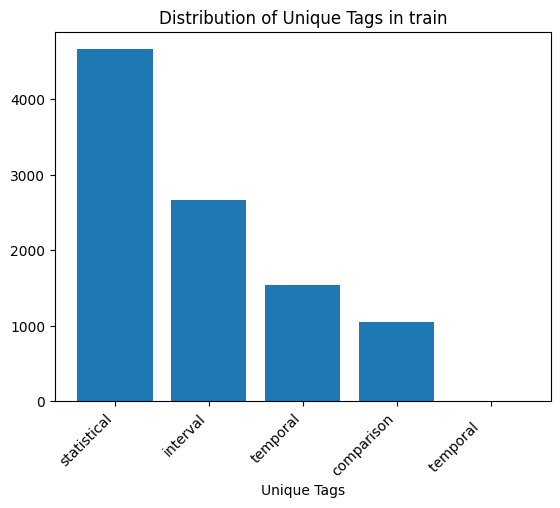

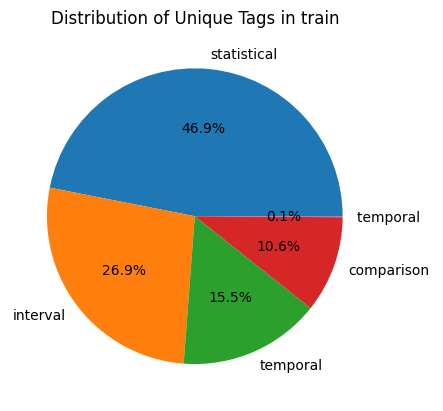

In [7]:
# Option 1: Bar Chart (for categorical data)
plt.bar(unique_tags_train, tag_counts_train)  # Use tag_counts if you want to visualize counts
plt.xlabel("Unique Tags")
plt.ylabel("Count" if 'tag_counts' in locals() else "")  # Adjust label if visualizing counts
plt.title("Distribution of Unique Tags in train")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.show()

# Option 2: Pie Chart (for categorical data with limited categories)
plt.pie(tag_counts_train, labels=unique_tags_train, autopct="%1.1f%%")  # Use tag_counts if visualizing counts
plt.title("Distribution of Unique Tags in train")
plt.show()

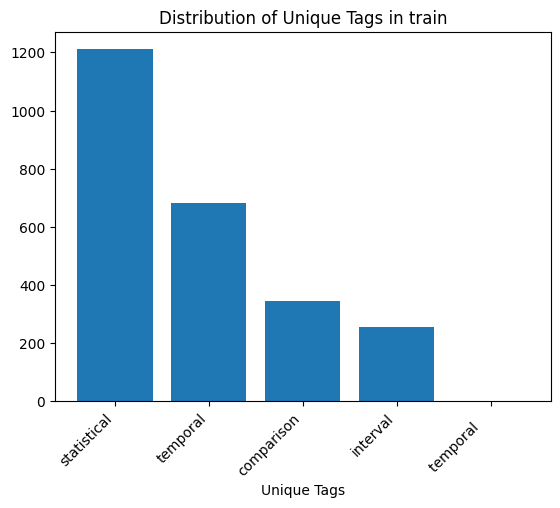

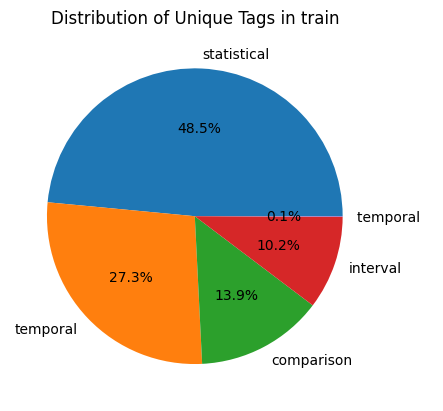

In [8]:
# Option 1: Bar Chart (for categorical data)
plt.bar(unique_tags_test, tag_counts_test)  # Use tag_counts if you want to visualize counts
plt.xlabel("Unique Tags")
plt.ylabel("Count" if 'tag_counts' in locals() else "")  # Adjust label if visualizing counts
plt.title("Distribution of Unique Tags in train")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.show()

# Option 2: Pie Chart (for categorical data with limited categories)
plt.pie(tag_counts_test, labels=unique_tags_test, autopct="%1.1f%%")  # Use tag_counts if visualizing counts
plt.title("Distribution of Unique Tags in train")
plt.show()

# Find Size of Train & Test Data

In [9]:
print(len(train_df))
print(len(test_df))

9935
2495


# Label Encoding Sense Labels

In [10]:
# Encode labels
label_encoder = LabelEncoder()
train_df['taxonomy_label'] = label_encoder.fit_transform(train_df['taxonomy_label'])
test_df['taxonomy_label'] = label_encoder.transform(test_df['taxonomy_label'])
valid_df['taxonomy_label'] = label_encoder.transform(valid_df['taxonomy_label'])

# Loading Bert Model

In [11]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [12]:
# Tokenize the text
def tokenize_function(sentences):
    return tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

# Tokenize the training and testing texts
train_encodings = tokenize_function(train_df['claim'].tolist())
test_encodings = tokenize_function(test_df['claim'].tolist())
valid_encodings = tokenize_function(valid_df['claim'].tolist())

In [13]:
# Create a custom dataset class
class SentenceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentenceDataset(train_encodings, train_df['taxonomy_label'].tolist())
test_dataset = SentenceDataset(test_encodings, test_df['taxonomy_label'].tolist())
valid_dataset = SentenceDataset(valid_encodings, valid_df['taxonomy_label'].tolist())

In [14]:
# Load the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=len(label_encoder.classes_))

# Setup Dataloaders

In [17]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
val_loader=DataLoader(valid_dataset, batch_size=4, shuffle=False)

# Training Phase

In [18]:
import time
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

def train(model, train_loader, val_loader, optimizer, device):
    model.train()
    total_loss = 0
    start_time = time.time()  # Track training start time

    for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training")):  # Use tqdm for progress bar
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    end_time = time.time()  # Track training end time
    training_time = end_time - start_time

    # Log training stats (optional)
    with open("training_log.txt", "a") as f:  # Create/append to a log file
        f.write(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Training Time: {training_time:.2f} seconds\n")

    # Validation
    model.eval()  # Set model to evaluation mode
    val_total_loss = 0

    with torch.no_grad():
        for val_batch in tqdm(val_loader, desc="Validation"):
            val_input_ids = val_batch['input_ids'].to(device)
            val_attention_mask = val_batch['attention_mask'].to(device)
            val_labels = val_batch['labels'].to(device)

            val_outputs = model(val_input_ids, attention_mask=val_attention_mask, labels=val_labels)
            val_loss = val_outputs.loss
            val_total_loss += val_loss.item()

    avg_val_loss = val_total_loss / len(val_loader)

    return avg_loss, avg_val_loss

# Train for 3 epochs
for epoch in range(1):
    train_loss, val_loss = train(model, train_loader, val_loader, optimizer, device)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 771/771 [00:08<00:00, 88.03it/s]

Epoch 1, Train Loss: 0.6908828688615966, Val Loss: 0.5686410199295144


# Evaluation

In [19]:
def evaluate(model, data_loader, device):
    model.eval()
    preds, true_labels = [], []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return np.array(true_labels), np.array(preds)

true_labels, preds = evaluate(model, test_loader, device)

# Compute Metrics

In [20]:
accuracy = accuracy_score(true_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='weighted')
classification_rep = classification_report(true_labels, preds)

print('Classification Report:')
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.87      0.63       255
           1       0.53      0.54      0.54       347
           2       0.88      0.75      0.81      1210
           3       0.88      0.86      0.87       681
           4       0.00      0.00      0.00         2

    accuracy                           0.76      2495
   macro avg       0.56      0.60      0.57      2495
weighted avg       0.79      0.76      0.77      2495



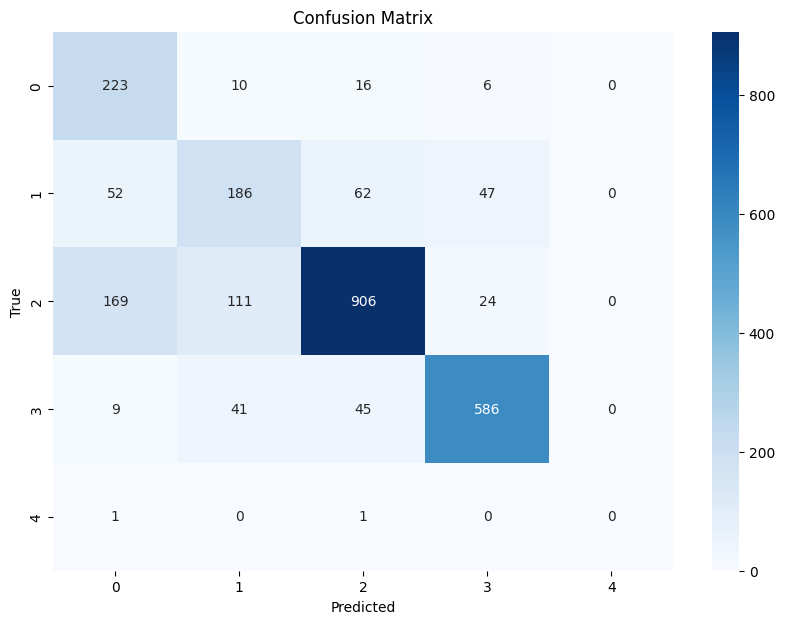

In [21]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming true_labels and preds are already defined
# true_labels = ...
# preds = ...

# Calculate metrics
accuracy = accuracy_score(true_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='weighted')
classification_rep = classification_report(true_labels, preds)
conf_matrix = confusion_matrix(true_labels, preds)


# Print confusion matrix
#print('Confusion Matrix:')
#print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# End of Code

In [22]:
# Define the directory path where you want to save the model
model_directory = "BERT-CLAIM-validation"

# Save the model
model.save_pretrained(model_directory)